In [2]:
%pip install kaggle

Note: you may need to restart the kernel to use updated packages.


Placer le fichier issue de kaggle API dans le dossier crée ici.


In [1]:
!mkdir kaggle
!mkdir dataset

mkdir: cannot create directory ‘kaggle’: File exists
mkdir: cannot create directory ‘dataset’: File exists


In [6]:
import os
import json
import zipfile

Suivre la démarche de récupération d'un token API kaggle : https://www.kaggle.com/settings
Ajouter le token API (fichier kaggle.json) au projet dans le dossier kaggle précédement crée.


In [3]:
kaggle_config_path = os.path.join("./kaggle/kaggle.json")

with open(kaggle_config_path, "r") as file:
    kaggle_credentials = json.load(file)

kaggle_username = kaggle_credentials["username"]
kaggle_key = kaggle_credentials["key"]

print("Kaggle Username:", kaggle_username)

Kaggle Username: mathieubaffoigne


In [5]:
os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

In [6]:
!kaggle datasets download -d grassknoted/asl-alphabet

100%|█████████████████████████████████████▉| 1.02G/1.03G [00:27<00:00, 44.8MB/s]
100%|██████████████████████████████████████| 1.03G/1.03G [00:27<00:00, 39.4MB/s]


In [7]:
with zipfile.ZipFile("./asl-alphabet.zip", "r") as zip_ref:
    zip_ref.extractall("./dataset")

In [8]:
main_directory = "./dataset/asl_alphabet_train/asl_alphabet_train/"

In [9]:
class_dirs = [class_dir for class_dir in os.listdir(
    main_directory) if os.path.isdir(os.path.join(main_directory, class_dir))]
class_dirs = sorted(class_dirs)
print(class_dirs)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [10]:
%pip install opencv-python numpy matplotlib pandas mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp

In [10]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

E0000 00:00:1710320355.928041   15991 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1710320355.928121   15991 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1710320355.928134   15991 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)


In [11]:
for class_dir in class_dirs:
    class_path = os.path.join(main_directory, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        mirrored_image = cv2.flip(image, 1)
        mirrored_image_path = os.path.join(class_path, "mirrored_" + image_file)
        cv2.imwrite(mirrored_image_path, mirrored_image)

In [12]:
keypoints_all = []

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(main_directory, class_dir)
    for j, image_file in enumerate(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = []
                for lm in hand_landmarks.landmark:
                    keypoints.append((lm.x, lm.y, lm.z))
                if keypoints:
                    keypoints_all.append({"label": class_dir, "keypoints": keypoints})

        total_images = len(class_dirs) * len(os.listdir(class_path))
        percentage = (i * len(os.listdir(class_path)) + j) / total_images * 100
        print(f"Progress: {percentage:.2f}% complete", end="\r")

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [13]:
df = pd.DataFrame(keypoints_all)

In [14]:
df.to_csv("./dataset_csv/keypoints_dataset_v2.csv", index=False)

In [121]:
df = pd.read_csv("./dataset_csv/keypoints_dataset_v2.csv")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128232 entries, 0 to 128231
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   label      128232 non-null  object
 1   keypoints  128232 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


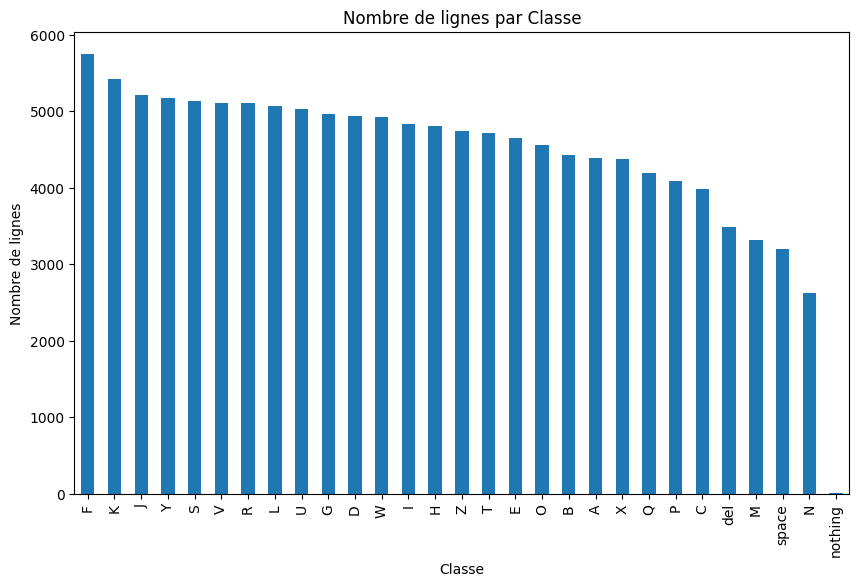

In [122]:
class_counts = df["label"].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre de lignes")
plt.title("Nombre de lignes par Classe")
plt.show()

In [123]:
labels_to_remove = ["J", "Z", "del", "space", "nothing"]
df = df[~df["label"].isin(labels_to_remove)]

In [124]:
label_with_min_rows = df["label"].value_counts().idxmin()
seuil_haut = df[df["label"] == label_with_min_rows].shape[0]
print("Number of rows for the label with the minimum instances:", seuil_haut)

Number of rows for the label with the minimum instances: 2624


In [125]:
seuil_bas = 50

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df["label"] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

df = df_filtered
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62976 entries, 0 to 62975
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      62976 non-null  object
 1   keypoints  62976 non-null  object
dtypes: object(2)
memory usage: 984.1+ KB


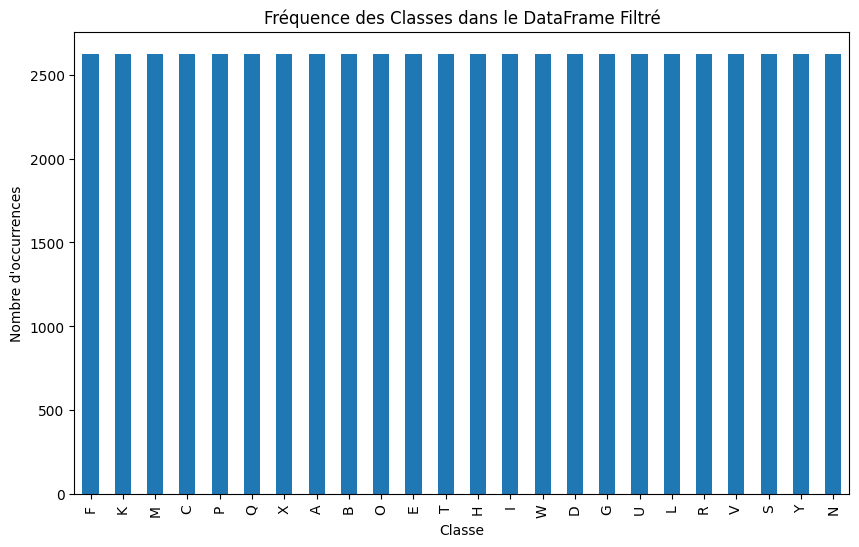

In [126]:
class_counts_filtered = df["label"].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.title("Fréquence des Classes dans le DataFrame Filtré")
plt.show()

In [22]:
%pip install plotly==5.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 26.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: plotly
    Found existing installation: plotly 5.18.0
    Uninstalling plotly-5.18.0:
      Successfully uninstalled plotly-5.18.0
Note: you may need to restart the kernel to use updated packages.


In [23]:
import plotly.graph_objects as go

In [127]:
image = eval(df.loc[0, 'keypoints'])

# Extract x, y, and z coordinates from image
x = [coord[0] for coord in image]
y = [coord[1] for coord in image]
z = [coord[2] for coord in image]

# Create a 3D scatter plot
fig = go.Figure(
    data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Add lines connecting the points
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines',
              line=dict(color='blue', width=2)))

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y',
                  zaxis_title='Z'), title='3D Plot of Coordinates')

# Show the plot
fig.show()

In [25]:
image = eval(df.loc[8200, 'keypoints'])

# Extract x, y, and z coordinates from image
x = [coord[0] for coord in image]
y = [coord[1] for coord in image]
z = [coord[2] for coord in image]

# Create a 3D scatter plot
fig = go.Figure(
    data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5))])

# Add lines connecting the points
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines',
              line=dict(color='blue', width=2)))

# Set labels and title
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y',
                  zaxis_title='Z'), title='3D Plot of Coordinates')

# Show the plot
fig.show()

In [128]:
df["keypoints"] = df["keypoints"].apply(eval)
df["keypoints"] = df["keypoints"].apply(lambda x: [list(val[:2]) for val in x])

In [129]:
def calculate_features_from_wrist(hand_landmarks):

    wrist = np.array([hand_landmarks[0][0], hand_landmarks[0][1]])
    angles = []
    distances = []

    for i in range(1, len(hand_landmarks)):
        keypoint = np.array([hand_landmarks[i][0], hand_landmarks[i][1]])
        vector_2d = keypoint[:2] - wrist[:2]
        angle_rad = np.arctan2(vector_2d[1], vector_2d[0])
        angle_deg = np.degrees(angle_rad)
        angles.append(angle_deg)
        
        distance = np.linalg.norm(keypoint - wrist)
        distances.append(distance)

    specific_keypoints_pairs = [
        (4, 8),
        (8, 12),
        (12, 16),
        (16, 20),
        (4, 17),
    ]
    for pair in specific_keypoints_pairs:
        point_a = np.array([hand_landmarks[pair[0]][0], hand_landmarks[pair[0]][1]])
        point_b = np.array([hand_landmarks[pair[1]][0], hand_landmarks[pair[1]][1]])
        specific_distance = np.linalg.norm(point_a - point_b)
        distances.append(specific_distance)

    return {"angles": angles, "distances": distances}

In [130]:
all_angles = []
all_distances = []

for _, row in df.iterrows():
    keypoints = row['keypoints']
    results = calculate_features_from_wrist(keypoints)
    all_distances.append(results['distances'])
    all_angles.append(results['angles'])
df['angles'] = all_angles
df['distances'] = all_distances

In [131]:
keypoint_indices = [0, 4, 8, 12, 16, 20]
for index in keypoint_indices:
    df[f'x_{index}'] = df['keypoints'].apply(lambda x: x[index][0])
    df[f'y_{index}'] = df['keypoints'].apply(lambda x: x[index][1])

In [132]:
angle_columns = df['angles'].apply(pd.Series)
distance_columns = df['distances'].apply(pd.Series)

angle_columns.columns = [f'angle_{i}' for i in angle_columns.columns]
distance_columns.columns = [f'dist_{i}' for i in distance_columns.columns]

df = pd.concat([df.drop(['angles', 'distances', 'keypoints'],
            axis=1), angle_columns, distance_columns], axis=1)
df.head()

,label,x_0,y_0,x_4,y_4,x_8,y_8,x_12,y_12,x_16,...,dist_15,dist_16,dist_17,dist_18,dist_19,dist_20,dist_21,dist_22,dist_23,dist_24
0,F,0.751623,0.879206,0.974737,0.683290,0.942880,0.676498,0.927124,0.559725,0.817870,...,0.407795,0.230957,0.310656,0.348629,0.367863,0.032573,0.117832,0.137144,0.150991,0.298694
1,F,0.381920,0.840289,0.226249,0.580078,0.247045,0.552264,0.300792,0.475434,0.414815,...,0.409289,0.237450,0.319472,0.366649,0.392646,0.034729,0.093764,0.121900,0.186863,0.299103
2,F,0.534935,0.744445,0.327278,0.423751,0.350305,0.384373,0.414593,0.255742,0.551235,...,0.513811,0.281164,0.371597,0.420663,0.456510,0.045617,0.143801,0.138883,0.172227,0.341994
3,F,0.708424,1.019820,0.866267,0.622580,0.831369,0.628359,0.695696,0.462051,0.460499,...,0.645316,0.319075,0.444528,0.504273,0.543297,0.035373,0.214629,0.238250,0.240778,0.458651
4,F,0.652600,0.748541,0.493699,0.384579,0.519707,0.366135,0.636326,0.242133,0.754498,...,0.531354,0.306925,0.402442,0.465034,0.506077,0.031884,0.170225,0.119131,0.192503,0.369235


In [133]:
X = df.drop(columns=["label"])
y = df["label"]

In [62]:
X.shape, y.shape

((12000, 57), (12000,))

In [33]:
%pip install -U scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [63]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [134]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42)

In [37]:
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier(),
    xgb.XGBClassifier()
]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Model: {type(model).__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")
    print()

KeyboardInterrupt: 

In [39]:
from sklearn.model_selection import GridSearchCV 

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

KeyboardInterrupt: 

In [136]:
model_xgb = xgb.XGBClassifier()

# param_grid = {
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'n_estimators': 300,
#     'gamma': 0,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# params = {
#     'eval_metric': 'precision',
#     'early_stopping_rounds': 10,
# }

# model_xgb.set_params(**params)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [144]:
model_svc = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(estimator=model_svc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
# model_svc.fit(X_train, y_train)
print('Meilleurs paramètres :', grid_search.best_params_)
print('Meilleur score :', grid_search.best_score_)

In [139]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    model_svc, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='accuracy', n_jobs=-1)

Train sizes: [ 4030  8060 12091 16121 20152 24182 28212 32243 36273 40304]
Train scores mean: [0.46689826 0.55885856 0.6104706  0.64441412 0.6779079  0.70012406
 0.72562739 0.74238749 0.75761034 0.77175963]
Train scores std: [0.00168734 0.00064516 0.00666273 0.0062236  0.00509918 0.00753986
 0.00528511 0.00574367 0.00336241 0.00413287]
Test scores mean: [0.43406114 0.53582771 0.59446209 0.63292973 0.66949186 0.69400556
 0.71897578 0.73809051 0.75210401 0.76659389]
Test scores std: [0.00363223 0.00129705 0.00489892 0.00811672 0.00520048 0.0051552
 0.00747515 0.00829614 0.00577757 0.00665447]


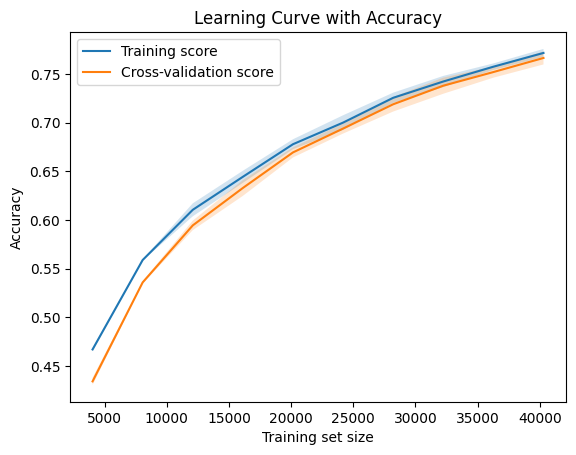

In [140]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print("Train sizes:", train_sizes)
print("Train scores mean:", train_scores_mean)
print("Train scores std:", train_scores_std)
print("Test scores mean:", test_scores_mean)
print("Test scores std:", test_scores_std)

# Tracer la courbe d'apprentissage pour la précision
plt.figure()
plt.title("Learning Curve with Accuracy")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
plt.legend(loc="best")
plt.show()

In [142]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import joblib

In [143]:
# y_pred = model_xgb.predict(X_test)
y_pred = model_svc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       502
           1       0.92      0.78      0.85       500
           2       0.94      0.96      0.95       549
           3       1.00      0.93      0.96       510
           4       0.50      0.53      0.52       489
           5       0.96      0.94      0.95       509
           6       0.96      0.99      0.97       520
           7       0.97      0.97      0.97       522
           8       0.61      0.42      0.50       571
           9       0.67      0.78      0.72       519
          10       0.91      0.93      0.92       511
          11       0.78      0.61      0.69       546
          12       0.84      0.81      0.82       524
          13       0.91      0.96      0.93       565
          14       0.95      0.94      0.94       549
          15       0.93      0.95      0.94       513
          16       0.55      0.76      0.64       542

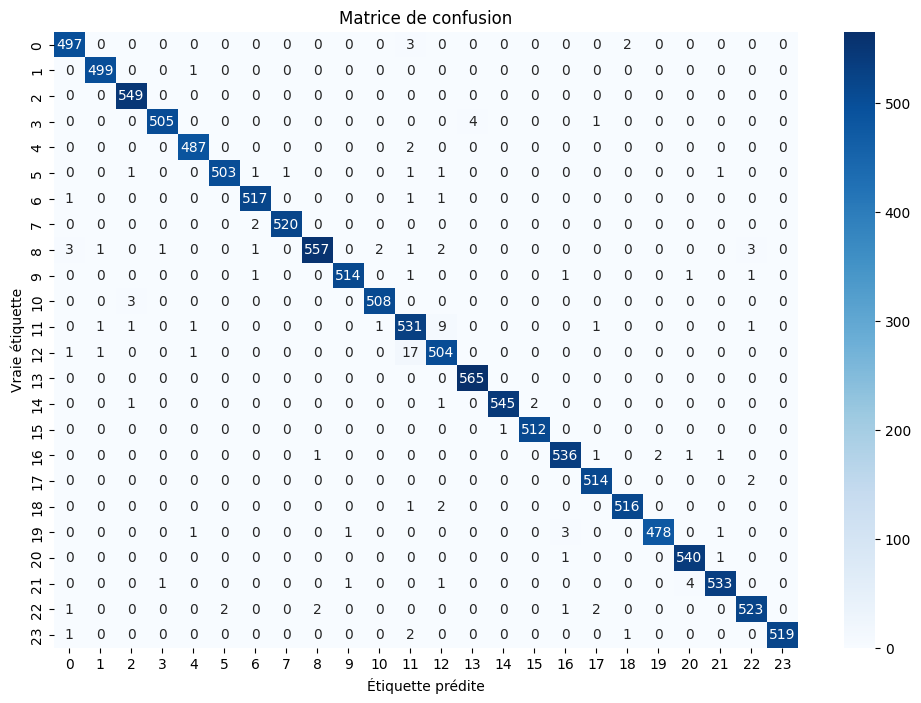

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
plt.ylabel("Vraie étiquette")
plt.xlabel("Étiquette prédite")
plt.title("Matrice de confusion")
plt.show()

In [45]:
joblib.dump(model_xgb, "./models/model_xgb_v2.pkl")

['./models/model_xgb_v2.pkl']